# Model OHE1
Here we start a series of models based on one-hot-encoding and stratified split of the data. We preprocess and clean the data, and then we do 
a grid search to tune the hyperparameters. Once found the bests (according to f1 score), we train the final model unifying training and validation set.

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from Cleaning_functions import *
from helpers import *
from exploratory_data_analysis import *
from preprocessing import *

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data\dataset\dataset")

In [3]:
Y_tr = (y_train + 1) / 2

In [4]:
X_train, keep_mask = remove_nan_features(x_train, 0.2)
X_test = x_test[:, keep_mask]

In [5]:
print(X_train.shape, X_test.shape)

(328135, 143) (109379, 143)


In [6]:
cat_mask, num_mask = detect_categorical_features(X_train, max_unique=10)

In [7]:
print(np.sum(cat_mask), np.sum(num_mask))

99 44


In [8]:
x_tr, y_tr, x_va, y_va, x_te, y_te = stratified_three_way_split(X_train, Y_tr)

In [9]:
print(X_train.shape, x_tr.shape, y_tr.shape, x_va.shape, y_va.shape, x_te.shape, y_te.shape)

(328135, 143) (229695, 143) (229695,) (49220, 143) (49220,) (49220, 143) (49220,)


In [10]:
# Numerical imputation (compute medians from training)
x_tr_imp, medians = impute_numerical(x_tr, num_mask)
# Apply same medians to val/test
x_va_imp, _ = impute_numerical(x_va, num_mask, medians)
x_te_imp, _ = impute_numerical(x_te, num_mask, medians)
x_test_imp, _ = impute_numerical(X_test, num_mask, medians)
# Categorical imputation (compute modes from training)
x_tr_imp, modes = impute_categorical(x_tr_imp, cat_mask)
# Apply same modes to val/test
x_va_imp, _ = impute_categorical(x_va_imp, cat_mask, modes)
x_te_imp, _ = impute_categorical(x_te_imp, cat_mask, modes)
x_test_imp, _ = impute_categorical(x_test_imp, cat_mask, modes)

In [11]:
# Check for any remaining NaN values
print(np.isnan(x_tr_imp).sum(),
      np.isnan(x_va_imp).sum(),
      np.isnan(x_te_imp).sum(), np.isnan(x_test_imp).sum())

0 0 0 0


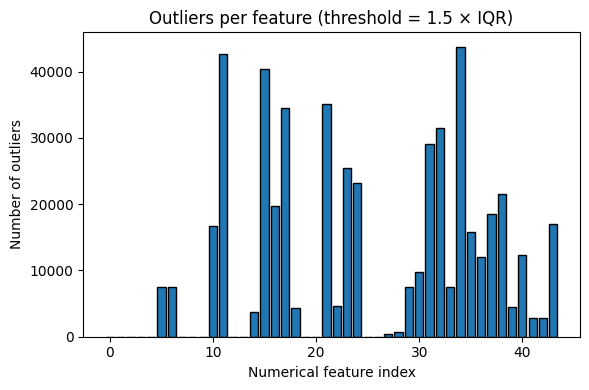

In [12]:
outlier_mask, outlier_counts = detect_outliers(x_tr_imp, num_mask, threshold=1.5, plot=True)

In [13]:
print(outlier_counts)

[    0     0     0     0     0  7523  7523     0     0     0 16765 42722
     0     0  3745 40468 19668 34545  4275     0     0 35062  4608 25522
 23171     0     0   441   754  7544  9823 29058 31441  7525 43748 15806
 12023 18456 21474  4498 12403  2772  2772 16957]


In [14]:
outlier_pctg = outlier_counts / x_tr_imp.shape[0]
print(outlier_pctg)

[0.         0.         0.         0.         0.         0.03275213
 0.03275213 0.         0.         0.         0.07298809 0.18599447
 0.         0.         0.01630423 0.17618146 0.08562659 0.15039509
 0.01861164 0.         0.         0.1526459  0.02006139 0.11111256
 0.10087725 0.         0.         0.00191994 0.00328261 0.03284355
 0.04276541 0.12650689 0.13688152 0.03276084 0.19046126 0.06881299
 0.05234332 0.08035003 0.09348919 0.01958249 0.05399769 0.01206818
 0.01206818 0.07382398]


In [15]:
drop_threshold = 0.1
new_num_mask = outlier_pctg < drop_threshold


In [16]:
#Change the mask again
keep_mask = np.ones(x_tr_imp.shape[1], dtype=bool)
num_indices = np.where(num_mask)[0]
keep_mask[num_indices] = new_num_mask

In [17]:
x_tr_filt = x_tr_imp[:, keep_mask]
x_va_filt = x_va_imp[:, keep_mask]
x_te_filt = x_te_imp[:, keep_mask]
x_test_filt = x_test_imp[:, keep_mask]
num_mask = num_mask[keep_mask]
cat_mask = cat_mask[keep_mask]

In [18]:
print(np.sum(num_mask), np.sum(cat_mask))

35 99


In [19]:
# Fit one-hot encoder on training data
x_tr_enc, categories = one_hot_encode(x_tr_filt, cat_mask, drop_first=True)

# Apply the same categories to validation and test data
x_va_enc, _ = one_hot_encode(x_va_filt, cat_mask, categories, drop_first=True)
x_te_enc, _ = one_hot_encode(x_te_filt, cat_mask, categories, drop_first=True)
x_test_enc, _ = one_hot_encode(x_test_filt, cat_mask, categories, drop_first=True)

In [20]:
print(x_tr_enc.shape, x_va_enc.shape, x_te_enc.shape, x_test_enc.shape) 

(229695, 359) (49220, 359) (49220, 359) (109379, 359)


In [21]:
cat_mask_enc, num_mask_enc = detect_categorical_features(x_tr_enc, max_unique=10)

In [22]:
print(np.sum(cat_mask_enc), np.sum(num_mask_enc))

324 35


In [23]:
print(np.max(x_tr_enc[:,cat_mask_enc]))

1.0


In [24]:
x_tr_std, means, stds = standardize_features(x_tr_enc, num_mask_enc)
x_va_std, _, _ = standardize_features(x_va_enc, num_mask_enc, means, stds)
x_te_std, _, _ = standardize_features(x_te_enc, num_mask_enc, means, stds)
x_test_std, _, _ = standardize_features(x_test_enc, num_mask_enc, means, stds)

In [25]:
corr_y = feature_target_correlation_2(x_tr_std, y_tr)


In [26]:
min_corr = 0.02
keep_mask_corr = np.abs(corr_y) > min_corr


In [27]:
x_tr_sel = x_tr_std[:, keep_mask_corr]
x_va_sel = x_va_std[:, keep_mask_corr]
x_te_sel = x_te_std[:, keep_mask_corr]
x_test_sel = x_test_std[:, keep_mask_corr]

In [28]:
print(x_tr_sel.shape, x_va_sel.shape, x_te_sel.shape, x_test_sel.shape)

(229695, 159) (49220, 159) (49220, 159) (109379, 159)


In [29]:
cat_mask_sel, num_mask_sel = detect_categorical_features(x_tr_sel, max_unique=10)

In [30]:
print(np.sum(cat_mask_sel))

141


In [31]:
corr_mat = correlation_matrix(x_tr_sel)


In [32]:
threshold = 0.85
to_drop = set()
for i in range(corr_mat.shape[0]):
    for j in range(i + 1, corr_mat.shape[1]):
        if abs(corr_mat[i, j]) > threshold:
            to_drop.add(j)
keep_mask_inter = np.ones(x_tr_sel.shape[1], dtype=bool)
keep_mask_inter[list(to_drop)] = False


In [33]:
x_tr_final = x_tr_sel[:, keep_mask_inter]
x_va_final = x_va_sel[:, keep_mask_inter]
x_te_final = x_te_sel[:, keep_mask_inter]
x_test_final = x_test_sel[:, keep_mask_inter]

In [34]:
print("Dropped (low corr):", np.sum(~keep_mask_corr))
print("Dropped (high inter):", np.sum(~keep_mask_inter))
print("Remaining features:", x_tr_final.shape[1])


Dropped (low corr): 200
Dropped (high inter): 34
Remaining features: 125


In [124]:
best_params, best_f1, results = grid_search(
    y_tr, x_tr_final,
    y_va, x_va_final,
    pos_weights=[7, 8, 9, 10, 11],
    lambdas=[1e-8, 1e-6, 1e-4],
    thresholds=np.linspace(0.6, 0.85, 20),
    max_iter=10000,
    gamma=0.5
)



=== Run 1/15 (pos_weight=7, lambda_=1e-08) ===
New best F1 = 0.4138
New best F1 = 0.4167
New best F1 = 0.4175
New best F1 = 0.4181
New best F1 = 0.4183

=== Run 2/15 (pos_weight=7, lambda_=1e-06) ===

=== Run 3/15 (pos_weight=7, lambda_=0.0001) ===

=== Run 4/15 (pos_weight=8, lambda_=1e-08) ===

=== Run 5/15 (pos_weight=8, lambda_=1e-06) ===

=== Run 6/15 (pos_weight=8, lambda_=0.0001) ===

=== Run 7/15 (pos_weight=9, lambda_=1e-08) ===

=== Run 8/15 (pos_weight=9, lambda_=1e-06) ===

=== Run 9/15 (pos_weight=9, lambda_=0.0001) ===

=== Run 10/15 (pos_weight=10, lambda_=1e-08) ===
New best F1 = 0.4185

=== Run 11/15 (pos_weight=10, lambda_=1e-06) ===

=== Run 12/15 (pos_weight=10, lambda_=0.0001) ===

=== Run 13/15 (pos_weight=11, lambda_=1e-08) ===

=== Run 14/15 (pos_weight=11, lambda_=1e-06) ===

=== Run 15/15 (pos_weight=11, lambda_=0.0001) ===

=== Grid Search Complete ===
Best F1 = 0.4185 at pos_weight=10, λ=1e-08, threshold=0.731578947368421


In [35]:
X_final = np.vstack([x_tr_final, x_va_final])
y_final = np.concatenate([y_tr, y_va])


In [36]:
best_lambda = 1e-8
best_pos_weight = 10.0
best_neg_weight = 1.0
best_threshold = 0.731578947368421

final_loss, w_final = logistic_regression_weighted_gd(
    y_final, X_final,
    lambda_=best_lambda,
    gamma=0.5,
    pos_weight=best_pos_weight,
    neg_weight=best_neg_weight,
    max_iter=10000,
    verbose=True
)

print("Final training loss:", final_loss)


Iter     0 | Loss = 0.693147 | GradNorm = 0.4257
Iter   100 | Loss = 0.478828 | GradNorm = 0.0122
Iter   200 | Loss = 0.474760 | GradNorm = 0.0068
Iter   300 | Loss = 0.473107 | GradNorm = 0.0049
Iter   400 | Loss = 0.472143 | GradNorm = 0.0039
Iter   500 | Loss = 0.471478 | GradNorm = 0.0034
Iter   600 | Loss = 0.470975 | GradNorm = 0.0030
Iter   700 | Loss = 0.470573 | GradNorm = 0.0027
Iter   800 | Loss = 0.470241 | GradNorm = 0.0025
Iter   900 | Loss = 0.469961 | GradNorm = 0.0023
Iter  1000 | Loss = 0.469720 | GradNorm = 0.0021
Iter  1100 | Loss = 0.469512 | GradNorm = 0.0020
Iter  1200 | Loss = 0.469329 | GradNorm = 0.0018
Iter  1300 | Loss = 0.469169 | GradNorm = 0.0017
Iter  1400 | Loss = 0.469026 | GradNorm = 0.0016
Iter  1500 | Loss = 0.468900 | GradNorm = 0.0015
Iter  1600 | Loss = 0.468786 | GradNorm = 0.0015
Iter  1700 | Loss = 0.468685 | GradNorm = 0.0014
Iter  1800 | Loss = 0.468593 | GradNorm = 0.0013
Iter  1900 | Loss = 0.468510 | GradNorm = 0.0013
Iter  2000 | Loss = 

In [37]:
print(w_final @ w_final)

19.725196493479928


In [38]:
acc, f1 = evaluate_model(y_te, x_te_final, w_final, best_threshold)

 Accuracy: 87.54%
 F1 Score: 0.4238


In [48]:
y_pred_final, _ = predict_with_threshold(x_test_final, w_final, best_threshold)
y_pred_final = 2 * y_pred_final - 1   # converts 0→-1, 1→1

create_csv_submission(test_ids, y_pred_final, "ModelOHE_preds.csv")

Confusion Matrix:
[[40833  4041]
 [ 2091  2255]]
TN=40833, FP=4041, FN=2091, TP=2255


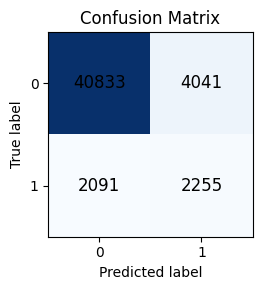

In [39]:
preds, _ = predict_with_threshold(x_te_final, w_final, threshold=best_threshold)
cm = confusion_matrix_numpy(y_te, preds)


In [43]:
best_lambda = 1e-7
best_pos_weight = 10.0
best_neg_weight = 1.0

final_loss, w_final = logistic_regression_weighted_gd(
    y_final, X_final,
    lambda_=best_lambda,
    gamma=0.5,
    pos_weight=best_pos_weight,
    neg_weight=best_neg_weight,
    max_iter=10000,
    verbose=True
)

print("Final training loss:", final_loss)

Iter     0 | Loss = 0.693147 | GradNorm = 0.4257
Iter   100 | Loss = 0.478828 | GradNorm = 0.0122
Iter   200 | Loss = 0.474760 | GradNorm = 0.0068
Iter   300 | Loss = 0.473107 | GradNorm = 0.0049
Iter   400 | Loss = 0.472143 | GradNorm = 0.0039
Iter   500 | Loss = 0.471478 | GradNorm = 0.0034
Iter   600 | Loss = 0.470975 | GradNorm = 0.0030
Iter   700 | Loss = 0.470573 | GradNorm = 0.0027
Iter   800 | Loss = 0.470241 | GradNorm = 0.0025


KeyboardInterrupt: 